# U-Net Model - Orbital Response

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torchvision import transforms
import torchvision.models as models

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as TF
import torch.optim as optim
from torchsummary import summary
from torch.nn.functional import one_hot

from torchmetrics.segmentation import GeneralizedDiceScore

from PIL import Image
from tqdm import tqdm

## Model Initialisation

### The Encoder

In [5]:
# Load pre-trained ResNet34 model
resnet34 = models.resnet34(pretrained=True)

/Users/BenedictShaw/.pyenv/versions/3.10.6/envs/orbital_response/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/BenedictShaw/.pyenv/versions/3.10.6/envs/orbital_response/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
resnet34.conv1 = nn.Conv2d(
    in_channels=6,   # 6 for pre + post RGB images
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

In [7]:
resnet34

ResNet(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Freezing all parameters in the pretrained model, other than those in the first layer (that have been trained)
for name, param in resnet34.named_parameters():
    if name.startswith('conv1'):
        param.requires_grad = True
    else:
        param.requires_grad = False

### The Decoder

In [9]:
# A function defining the convolution block
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels)
    )

### Combining the Decoder to Form the U-Net

The **forward()** function defines the data flow through your model — it's how the model transforms input data into an output using its layers.

In [10]:
# Defining the U-Net model class
class UNetModel(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()

        # Encoder (modified for 6-channel input)
        self.encoder = resnet34

        # Decoder blocks with transpose convolutions
        self.up5 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec5 = conv_block(512 + 256, 256)

        self.up4 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.dec4 = conv_block(256 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(128 + 64, 64)

        self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(64 + 64, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        e2 = self.encoder.layer1(self.encoder.maxpool(e1))
        e3 = self.encoder.layer2(e2)
        e4 = self.encoder.layer3(e3)
        e5 = self.encoder.layer4(e4)

        d5 = self.dec5(torch.cat([self.up5(e5), e4], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d5), e3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e2], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e1], dim=1))

        out = self.final_conv(d2)
        return F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=False)


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(n_classes=5).to(device)
summary(model, input_size=(6, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]          18,816
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Dataset and DataLoader

*Concatenate “pre” and “post” 3-channel disaster images from each pair into a single tensor with 6 channels and use it as an input to the U-Net model. The 'target' is the single channel post-disaster mask.*

**NOTE: designed to retrieve images from local file**

Here, we are using the Pytorch Dataset class to control the loading of image data (features + labels) and the transformations that are applied (concatonation)

In [12]:
#Testing image to tensor
img_path = "../data/data_primary/processed/masks/hurricane-florence_00000000_post_disaster_mask.png"
img = Image.open(img_path)
mask_np = np.array(img)
mask_tensor = torch.from_numpy(mask_np).long()
unique_vals, counts = torch.unique(mask_tensor, return_counts=True)
print(dict(zip(unique_vals.tolist(), counts.tolist())))

{0: 917767, 1: 130809}


In [13]:
img_dir_test = "../data/data_primary/processed/split/train/images"
len(os.listdir(img_dir_test))
mask_dir_test = "../data/data_primary/processed/split/train/masks"
len(os.listdir(mask_dir_test))

214

In [14]:
# Specifying a class for mask transformation (png to tensor)
class MaskTransform:
    def __init__(self, size=(224, 224)):
        self.size = size

    def __call__(self, mask):
        # Resize using NEAREST interpolation to preserve class values
        mask = TF.resize(mask, self.size, interpolation=transforms.InterpolationMode.NEAREST)
        # Convert to LongTensor of class indices
        return torch.as_tensor(np.array(mask), dtype=torch.long)

MaskTransform()

In [15]:
mask_transform = MaskTransform(size=(224, 224))

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [16]:
class PrimaryDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.image_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.transform = transform
        self.mask_transform = mask_transform

        # Find all base mask IDs (e.g. "hurricane-florence_00000000")
        all_mask_files = os.listdir(self.mask_dir)
        self.ids = sorted(list(set(
            f.replace("_pre_disaster_mask.png", "").replace("_post_disaster_mask.png", "")
            for f in all_mask_files
            if f.endswith(".png")
        )))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]

        # File paths
        pre_path = os.path.join(self.image_dir, f"{image_id}_pre_disaster.png")
        post_path = os.path.join(self.image_dir, f"{image_id}_post_disaster.png")
        post_mask_path = os.path.join(self.mask_dir, f"{image_id}_post_disaster_mask.png")

        # Open images
        pre_img = Image.open(pre_path)
        post_img = Image.open(post_path)
        post_mask = Image.open(post_mask_path)

        # Apply image transforms
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)

        image = torch.cat([pre_img, post_img], dim=0)  # shape: [6, H, W]

        # Apply mask transforms
        if self.mask_transform:
            post_mask = self.mask_transform(post_mask)

        return image, post_mask

In [17]:
post_mask = mask_transform(Image.open("../data/data_primary/processed/masks/hurricane-florence_00000048_post_disaster_mask.png"))
df = pd.DataFrame(post_mask)
df[20].value_counts()

20
0    216
3      8
Name: count, dtype: int64

## Model Training 

In [18]:
# Empty the torch cache, which may slow the training process
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading in the train, val and test data.

In [19]:
train_dataset = PrimaryDataset("../data/data_primary/processed/split/train/", transform=img_transform, mask_transform=mask_transform)
val_dataset = PrimaryDataset("../data/data_primary/processed/split/val/", transform=img_transform, mask_transform=mask_transform)
test_dataset = PrimaryDataset("../data/data_primary/processed/split/test/", transform=img_transform, mask_transform=mask_transform)

In [20]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 10

train_dataloader = DataLoader(dataset=train_dataset,
                              pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

### Model initialisation, and defining model parameters.

In [21]:
# Initialising the model
model = UNetModel(n_classes=5).to(device)

optimizer = optim.Adam(model.parameters(),lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [22]:
# Instantiating Generalised Dice Score function (inputs --> preds, target)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gds = GeneralizedDiceScore(num_classes=5).to(device)

In [23]:
def compute_loss_and_dice(y_pred, mask, criterion, gds):
    if mask.dim() == 4:
        mask = torch.argmax(mask, dim=1)  # [B, H, W]

    loss = criterion(y_pred, mask)

    y_prob = F.softmax(y_pred, dim=1)
    mask_onehot = one_hot(mask, num_classes=y_pred.shape[1]).permute(0, 3, 1, 2)

    dice = gds(y_prob, mask_onehot)

    return loss, dice

### The training loop:

In [36]:
EPOCHS = 10

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0

    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].long().to(device)

        y_pred = model(img)
        optimizer.zero_grad()

        loss, dice = compute_loss_and_dice(y_pred, mask, criterion, gds)

        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        train_running_dc += dice.item()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)

    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0

    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].long().to(device)

            y_pred = model(img)
            loss, dice = compute_loss_and_dice(y_pred, mask, criterion, gds)

            val_running_loss += loss.item()
            val_running_dc += dice.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)

    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)


 10%|█         | 1/10 [00:38<05:47, 38.63s/it]

------------------------------
Training Loss EPOCH 1: 1.6401
Training DICE EPOCH 1: 0.0181


Validation Loss EPOCH 1: 1.5002
Validation DICE EPOCH 1: 0.0146
------------------------------


 20%|██        | 2/10 [01:16<05:06, 38.30s/it]

------------------------------
Training Loss EPOCH 2: 1.6400
Training DICE EPOCH 2: 0.0095


Validation Loss EPOCH 2: 1.5304
Validation DICE EPOCH 2: 0.0178
------------------------------


 30%|███       | 3/10 [01:54<04:25, 37.95s/it]

------------------------------
Training Loss EPOCH 3: 1.6404
Training DICE EPOCH 3: 0.0171


Validation Loss EPOCH 3: 1.5629
Validation DICE EPOCH 3: 0.0209
------------------------------


 40%|████      | 4/10 [02:32<03:47, 37.89s/it]

------------------------------
Training Loss EPOCH 4: 1.6400
Training DICE EPOCH 4: 0.0154


Validation Loss EPOCH 4: 1.6331
Validation DICE EPOCH 4: 0.0114
------------------------------


 50%|█████     | 5/10 [03:09<03:09, 37.90s/it]

------------------------------
Training Loss EPOCH 5: 1.6405
Training DICE EPOCH 5: 0.0110


Validation Loss EPOCH 5: 1.6568
Validation DICE EPOCH 5: 0.0162
------------------------------


 60%|██████    | 6/10 [03:48<02:31, 37.97s/it]

------------------------------
Training Loss EPOCH 6: 1.6402
Training DICE EPOCH 6: 0.0128


Validation Loss EPOCH 6: 1.6550
Validation DICE EPOCH 6: 0.0255
------------------------------


 70%|███████   | 7/10 [04:26<01:54, 38.07s/it]

------------------------------
Training Loss EPOCH 7: 1.6404
Training DICE EPOCH 7: 0.0066


Validation Loss EPOCH 7: 1.6558
Validation DICE EPOCH 7: 0.0091
------------------------------


 80%|████████  | 8/10 [05:05<01:16, 38.33s/it]

------------------------------
Training Loss EPOCH 8: 1.6402
Training DICE EPOCH 8: 0.0107


Validation Loss EPOCH 8: 1.6480
Validation DICE EPOCH 8: 0.0092
------------------------------


 90%|█████████ | 9/10 [05:44<00:38, 38.75s/it]

------------------------------
Training Loss EPOCH 9: 1.6403
Training DICE EPOCH 9: 0.0128


Validation Loss EPOCH 9: 1.6640
Validation DICE EPOCH 9: 0.0174
------------------------------


100%|██████████| 10/10 [06:24<00:00, 38.46s/it]

------------------------------
Training Loss EPOCH 10: 1.6401
Training DICE EPOCH 10: 0.0115


Validation Loss EPOCH 10: 1.6545
Validation DICE EPOCH 10: 0.0134
------------------------------


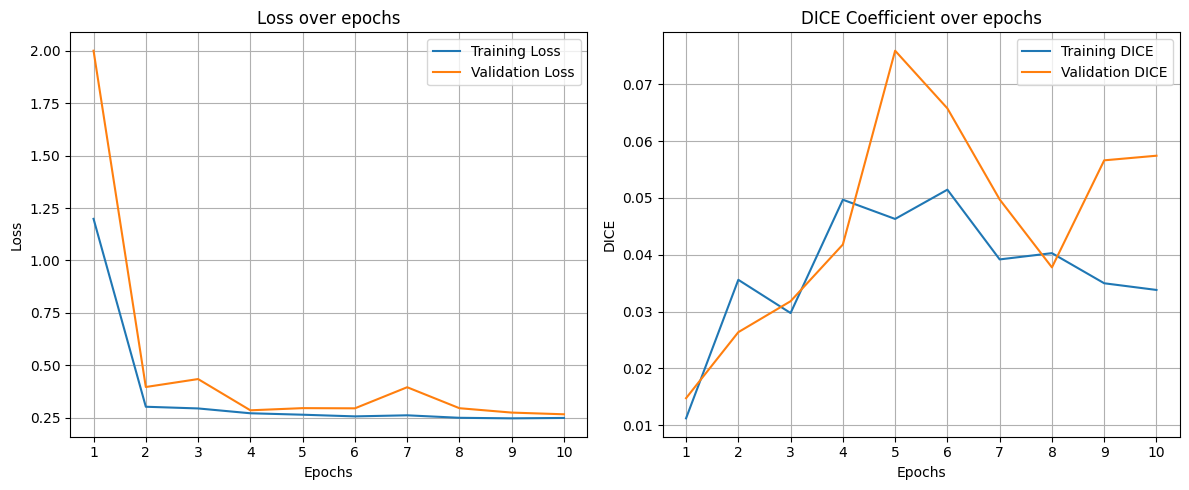

In [25]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()


plt.tight_layout()
plt.show()

## Model Evaluation

In [26]:
test_running_loss = 0
test_running_dc = 0

model.eval()  # ensure dropout/batchnorm behave correctly

with torch.no_grad():
    for idx, (img, mask) in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img.float().to(device)
        mask = mask.long().to(device)  # correct dtype for class labels

        y_pred = model(img)
        loss, dc = compute_loss_and_dice(y_pred, mask, criterion, gds)  # ensure this handles mask + softmax correctly

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice Score: {test_dc:.4f}")


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

Test Loss: 0.2168
Test Dice Score: 0.0605


## Saving the Model

In [27]:
torch.save(model.state_dict(), '../orbital_response/models/unet_bs001.pth')

## Loading the Model

In [37]:
import os
import sys

sys.path.append(os.path.abspath(".."))  # or relative path to project root

from orbital_response.ml_logic.model.model import get_model

In [38]:
import inspect
from orbital_response.ml_logic.model.model import get_model, UNetModel

model = get_model(n_classes=5)

print("🔎 UNetModel source:", inspect.getsourcefile(UNetModel))
print("🔎 get_model source:", inspect.getsourcefile(get_model))
print("🚀 Model architecture:")
print(model)

/Users/BenedictShaw/.pyenv/versions/3.10.6/envs/orbital_response/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/BenedictShaw/.pyenv/versions/3.10.6/envs/orbital_response/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔎 UNetModel source: /Users/BenedictShaw/code/benshaw0/orbital-response/orbital_response/ml_logic/model/model.py
🔎 get_model source: /Users/BenedictShaw/code/benshaw0/orbital-response/orbital_response/ml_logic/model/model.py
🚀 Model architecture:
UNetModel(
  (encoder): ResNet(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=

In [39]:
model_pth = '../orbital_response/models/unet_bs001.pth'

def load_model():
    model = get_model(n_classes=5)
    state_dict = torch.load(model_pth, map_location=torch.device("cpu"))

    try:
        model.load_state_dict(state_dict)
    except RuntimeError as e:
        print("❌ Failed to load model:", e)

    model.eval()
    return model

In [40]:
model_1 = load_model().to(device)

In [41]:
## images for test the model
pre_path = "../data/data_primary/processed/images/hurricane-florence_00000048_pre_disaster.png"
post_path = "../data/data_primary/processed/images/hurricane-florence_00000048_post_disaster.png"

pre_img = Image.open(pre_path)
post_img = Image.open(post_path)

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Apply transform and concat
pre_tensor = img_transform(pre_img)
post_tensor = img_transform(post_img)
input_tensor = torch.cat([pre_tensor, post_tensor], dim=0).unsqueeze(0).to(device)  # [1, 6, 224, 224]

output_tensor = model_1(input_tensor)

## Conversion of Output Mask to RGB .png File

In [42]:
CLASS_COLORS = {
    0: (0, 0, 0),         # un-classified (black)
    1: (0, 255, 0),       # no-damage (green)
    2: (0, 0, 255),     # minor-damage (blue)
    3: (255, 165, 0),     # major-damage (orange)
    4: (255, 0, 0),       # destroyed (red)
}

def mask_to_rgb(mask_tensor):
    mask_np = mask_tensor.cpu().numpy()
    h, w = mask_np.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in CLASS_COLORS.items():
        rgb[mask_np == class_idx] = color
    return Image.fromarray(rgb)

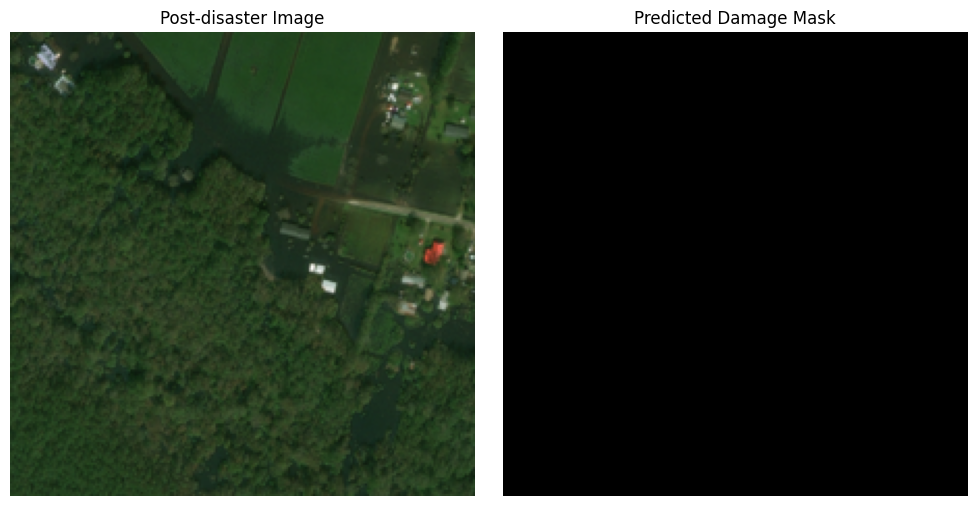

In [43]:
model.eval()
with torch.no_grad():
    output = model(input_tensor)  # [1, 5, H, W]
    pred_mask = torch.argmax(output, dim=1)[0]  # [H, W]

# prediction to RGB
rgb_mask = mask_to_rgb(pred_mask)

import matplotlib.pyplot as plt

original_img = post_img.resize((224, 224))

# Visualizar ambas
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Post-disaster Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rgb_mask)
plt.title("Predicted Damage Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

## Overlaying Mask onto Post-Disaster Image

In [44]:
blended_img = Image.blend(original_img, rgb_mask, alpha=0.5)

# Display the result
blended_img.show()